
# Plot Metrics from `results/generated_*`

This notebook scans folders like `results/generated_5`, `results/generated_10`, ..., `results/generated_60`,
reads each `metrics.csv` (columns: `total_waiting_time,total_energy_waste`), and produces **two bar charts**:

1. **Energy Waste vs Folder** — y = `total_energy_waste`, x = folder number (5,10,...,60).
2. **Waiting Time vs Folder** — y = `total_waiting_time`, x = folder number (5,10,...,60).

The figures are also saved to `results/plots/`.


In [25]:
# Cell 1: Imports and Setup
import os
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# This ensures plots appear in the notebook
%matplotlib inline

In [26]:
# Cell 2: Define Paths (This cell is optional, as it's redefined in the main block)
# You can keep this or remove it, the main block at the end is what matters.
results_dir = Path('resultss')
output_dir  = results_dir / 'plots'
output_dir.mkdir(parents=True, exist_ok=True)
print('Results dir:', results_dir.resolve())
print('Output dir :', output_dir.resolve())

Results dir: /Users/alfaa/Arsitektur UGM/SPARS-AIBT-2025/resultss
Output dir : /Users/alfaa/Arsitektur UGM/SPARS-AIBT-2025/resultss/plots


In [27]:
# Cell 2: Function Definitions
def collect_metrics(results_dir: Path, custom_policy_folder: str, custom_policy_label: str):
    """
    Collects TOTAL metrics from all experiment folders. The average will be calculated later.
    """
    pat = re.compile(r'^generated_(300|600|900|1200|1500|1800|2100|2400|2700|3000|3300|3600)$')
    rows = []

    def _get_total_metrics_from_csv(csv_path: Path):
        """A helper function to read TOTAL energy waste and TOTAL waiting time."""
        try:
            df = pd.read_csv(csv_path)
            df.columns = [c.lower().strip() for c in df.columns]
            
            te = float(df['total_energy_waste'].iloc[0])
            tw = float(df['total_waiting_time'].iloc[0])
            return te, tw
        except Exception as e:
            print(f"[WARN] Failed to read or parse {csv_path}: {e}")
            return None

    # Part 1: Collect metrics from the 12 baseline runs
    for entry in results_dir.iterdir():
        if not entry.is_dir() or not pat.match(entry.name):
            continue
        
        k = int(pat.match(entry.name).group(1))
        csv_path = entry / 'metrics.csv'
        if csv_path.is_file():
            metrics = _get_total_metrics_from_csv(csv_path)
            if metrics:
                rows.append((str(k), metrics[0], metrics[1]))

    rows.sort(key=lambda x: int(x[0]))
    
    # Part 2: Collect metrics from your custom policy folder
    custom_path = results_dir / custom_policy_folder
    if custom_path.is_dir():
        csv_path = custom_path / 'metrics.csv'
        if csv_path.is_file():
            metrics = _get_total_metrics_from_csv(csv_path)
            if metrics:
                rows.append((custom_policy_label, metrics[0], metrics[1]))
        else:
            print(f"[WARN] 'metrics.csv' not found in your custom folder: {custom_path}")
    else:
        print(f"[WARN] Custom policy folder '{custom_policy_folder}' not found in {results_dir}")
            
    return rows

def plot_bars(xs, ys, xlabel, ylabel, title, out_path):
    """Plots a bar chart."""
    idx = np.arange(len(xs))
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(idx, ys, width=0.9)

    ax.set_xticks(idx, xs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.xticks(rotation=45, ha="right")
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    for rect in bars:
        height = rect.get_height()
        ax.annotate(f'{height:,.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=7)

    fig.tight_layout()
    fig.savefig(out_path, dpi=150)
    plt.show()


Final summary of all runs:


,Policy,Total Wasted Energy (Joule),Average Job Waiting Time (second)
0,300,7.919918e+09,1636.675928
1,600,8.396796e+09,994.751719
2,900,8.276493e+09,979.076066
3,1200,8.570626e+09,745.003714
4,1500,9.080704e+09,578.051444
5,1800,9.504264e+09,532.460110
6,2100,9.718622e+09,506.470564
7,2400,9.885322e+09,440.388308
8,2700,1.013903e+10,406.382531
9,3000,1.048901e+10,382.570151


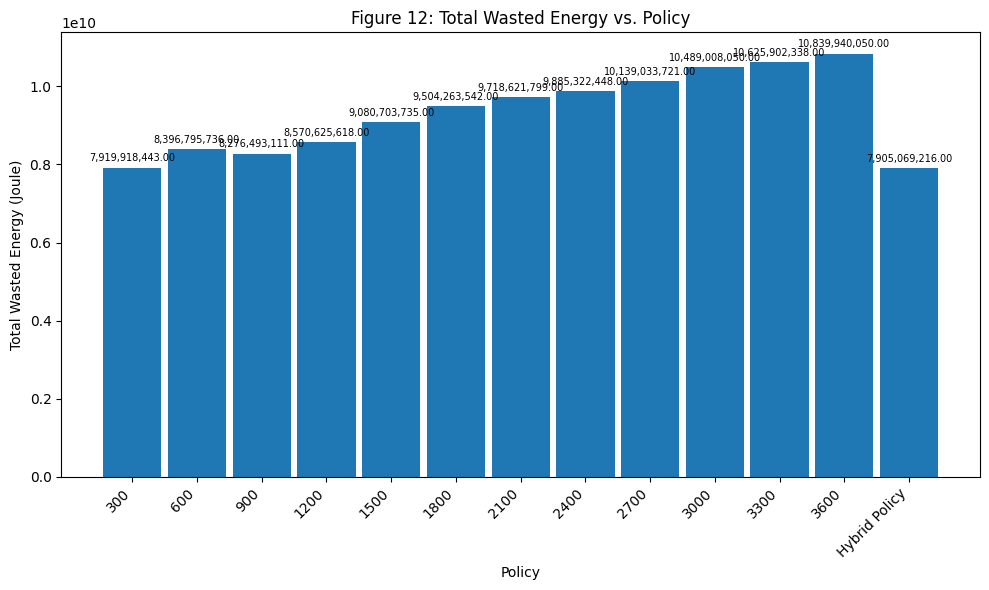

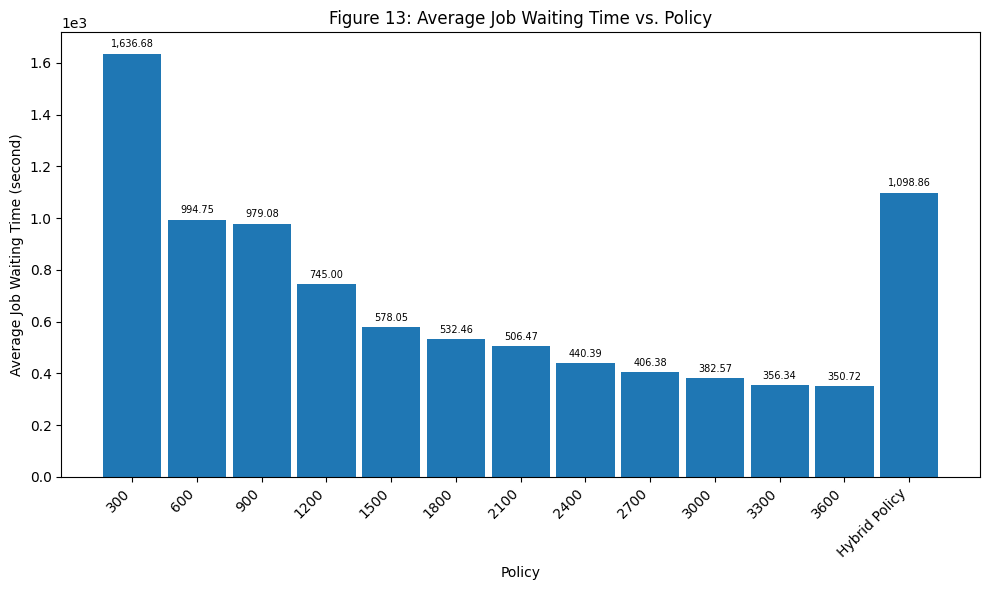


Saved: resultss/plots/final_summary.csv
Saved: resultss/plots/Figure12_Energy_Waste.png
Saved: resultss/plots/Figure13_Waiting_Time.png


In [28]:
# Cell 3: Main Execution Block
# =========================================================================
# 1. Define paths, labels, and the number of jobs
results_dir = Path("resultss")
output_dir = results_dir / 'plots'
output_dir.mkdir(exist_ok=True)

custom_folder_name = "run_hybrid"
custom_plot_label = "Hybrid Policy"

# --- !! CRITICAL !! ---
# You must provide the correct number of jobs in the workload to calculate the average.
# Open "Tugas_Project/nasa-20-back.json" and count the number of jobs.
# For example, if there are 7,270 jobs, set this to 7270.
# I will use a placeholder of 7270 for now.
NUM_JOBS_IN_WORKLOAD = 7270

# 2. Collect the data
rows = collect_metrics(results_dir, custom_folder_name, custom_plot_label)

if not rows:
    raise SystemExit("Execution stopped: No metric files could be successfully read.")
else:
    # 3. Process and display data
    xs = [r[0] for r in rows]
    tew = [r[1] for r in rows]
    # Calculate the average waiting time here
    total_wait_times = [r[2] for r in rows]
    avg_wait_times = (np.array(total_wait_times) / NUM_JOBS_IN_WORKLOAD).tolist()

    summary = pd.DataFrame({'Policy': xs, 'Total Wasted Energy (Joule)': tew, 'Average Job Waiting Time (second)': avg_wait_times})
    summary_path = output_dir / 'final_summary.csv'
    summary.to_csv(summary_path, index=False)
    print("Final summary of all runs:")
    display(summary)

    # 4. Plot the final graphs
    plot_bars(xs, tew, 'Policy', 'Total Wasted Energy (Joule)',
              'Figure 12: Total Wasted Energy vs. Policy', output_dir / 'Figure12_Energy_Waste.png')
    
    plot_bars(xs, avg_wait_times, 'Policy', 'Average Job Waiting Time (second)',
              'Figure 13: Average Job Waiting Time vs. Policy', output_dir / 'Figure13_Waiting_Time.png')

    print("\nSaved:", summary_path)
    print("Saved:", output_dir / 'Figure12_Energy_Waste.png')
    print("Saved:", output_dir / 'Figure13_Waiting_Time.png')